calculating the rotation curve of the Milky Way in the LSR. 
utilizing the radial and tangental velocity of an HI cloud in the galaxy.

Importing the necessary libraries and the coordinates of the Sun in the LSR frame.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
import astropy.coordinates as coord
import astropy.units as u
coord.galactocentric_frame_defaults.set("latest")
v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()
gal_sun_v = v_sun.norm()
gal_sun_r = 8 * u.kpc
gal_sun_l = 0 * u.rad

known properties: l, b,radial velocity.
It is best if you also know the distance of your target source from us or its radius from the galactic center. If not you can calculate both from the functions given below. First calculate the distance with distance_to_sun() and then the galactic radius gal_rad().

In [12]:
def Urad(radial_velocity, gal_long,gal_sun_v):
    return radial_velocity + gal_sun_v*sin(np.radians(gal_long))

#if the objects distance from the sun is known
def gal_radius(distance, gal_long,gal_sun_r):
    return np.sqrt(distance**2 + gal_sun_r**2 -(2*distance*gal_sun_r*np.cos(np.radians(gal_long))))

#if the objects radius to the galactic center is known:
def distance_to_sun(radial_velocity, gal_long):
    A = 15.3
    return np.abs(radial_velocity)/(A*np.sin(2*np.radians(gal_long)))

def relative_tangental_vel(distance,gal_long):
    A = 15.3
    B = -11.9
    return distance*((A*np.cos(2*np.radians(gal_long)))+B)

def total_velocity( radial_velocity,tangental_velocity):
    return np.sqrt(radial_velocity**2 + tangental_velocity**2)

def errors(gal_rad, gal_long, distance, total_vel,gal_sun_r):
    s = distance - (gal_sun_r*np.cos(np.radians(gal_long)))
    durad= 5 #km/s
    dr = 0.2 #kpc
    rad_vel_er=(gal_rad/(gal_sun_r*np.sin(np.radians(gal_long))))*durad
    radius_er=np.abs((s*total_vel/gal_rad**2)*dr)
    total_er = np.sqrt((rad_vel_er)**2 + (radius_er)**2)
    return radius_er, total_er



Import your data in the form of csv or txt file.

In [5]:
data=pd.read_csv("/Users/User/Documents/ΠΑΝΑΓΙΩΤΑ/SOFTWARE_ASTRO/test2.txt",sep='\s+', header=None, skiprows=0, names=['l', 'b', 'radial_velocity', 'radius'])
#data=data.drop(data[data['radius']>15].index)
data['d']=distance_to_sun(data['radial_velocity'], data['l'])
data['tang_vel']=relative_tangental_vel(data['d'], data['l'])
data['total_vel']=total_velocity(data['radial_velocity']+(gal_sun_v*np.sin(np.radians(data['l']))),data['tang_vel']+(gal_sun_v*np.cos(np.radians(data['l']))))
data['r_error'], data['total_u_error']=errors(data['radius'], data['l'], data['d'], data['total_vel'], gal_sun_r)
pd.options.display.float_format = '{:.2f}'.format
data= data.sort_values(by='radius', ascending=True)
print(data)


     l  b  radial_velocity  radius     d  tang_vel  total_vel  r_error  \
0   35  0            -7.20    8.80  0.50     -3.34     239.23     3.74   
9   44  0            -7.40    8.90  0.48     -5.50     236.97     3.15   
3   50  0            -7.20    9.00  0.48     -6.96     236.08     2.72   
18  55  0            -7.40    9.20  0.51     -8.82     234.96     2.26   
12  59  0            -7.40    9.40  0.55    -10.45     234.39     1.90   
27  60  0            -7.40    9.40  0.56    -10.92     234.26     1.82   
1   35  0           -23.90    9.80  1.66    -11.08     223.67     2.28   
6   65  0            -7.20    9.80  0.61    -13.35     234.07     1.35   
10  44  0           -28.00   10.40  1.83    -20.81     211.72     1.54   
4   50  0           -23.90   10.50  1.59    -23.09     212.92     1.37   
21  70  0            -7.40   10.60  0.75    -17.77     233.46     0.82   
2   35  0           -42.50   10.90  2.96    -19.71     206.88     1.25   
19  55  0           -30.10   11.60  2.

Fitting

For the fitting, the exponential disk model is used. You can also try the keplerian model as it is the one that theoriticaly should fit your data. However, the exponential model fits the data better.

As a next step you can also calculate the galaxy's mass as it will be by then known its rotational velocity. (Use the uo variable)

Fitted parameters - fiting: u0 = 252.07046700476818, R = 7.000000000000001


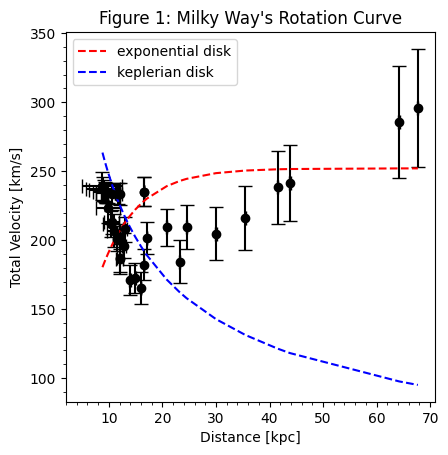

In [10]:
def fiting(r, u0, R):
    return u0*(1-np.exp(-r/R))
popt, pcov = curve_fit(fiting, data['radius'], data['total_vel'],p0=[240,8],bounds = ([220, 7], [260, 9]))
u0, R = popt
print(f"Fitted parameters - fiting: u0 = {u0}, R = {R}")

def keplerian_model(r,A):
    return np.sqrt(A/r)
popt2, pcov2 = curve_fit(keplerian_model, data['radius'], data['total_vel'])
A = popt2


#plt.scatter(data['radius'], data['total_vel'], color='black', s=10)
plt.errorbar(data['radius'], data['total_vel'], xerr=data['r_error'], yerr=data['total_u_error'], fmt='o', capsize=5, color='black')
plt.plot(data['radius'], fiting(data['radius'],*popt), color='red', linestyle='--', label='exponential disk')
plt.plot(data['radius'], keplerian_model(data['radius'],*popt2), color='blue', linestyle='--', label='keplerian disk')
plt.title("Figure 1: Milky Way's Rotation Curve")
ax1=plt.gca()
ax1.set_xlabel("Distance [kpc]")
#ax1.set_xlim([0,50])
#ax1.set_ylim([0,250])
ax1.set_ylabel("Total Velocity [km/s]")
ax1.yaxis.get_ticklocs(minor=True)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_box_aspect(1.0)
plt.legend()
plt.show()

Visualize your target sources in a polar plot (shows their position in the galaxy)

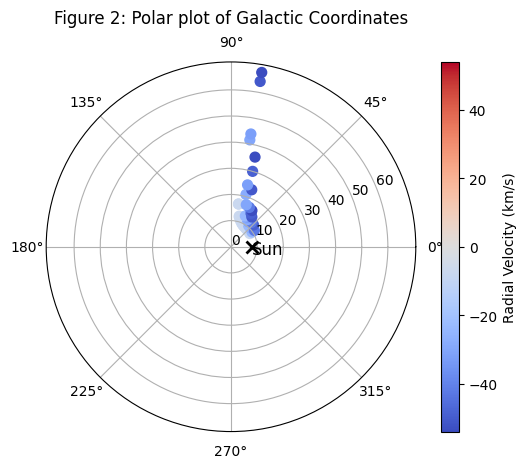

In [7]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

cmap = plt.get_cmap('coolwarm', 256)
norm = cm.colors.Normalize(vmin=np.min(data['radial_velocity']), vmax=np.abs(np.min((data['radial_velocity']))))

mapped_colors = cmap(norm(data['radial_velocity']))
ax.scatter(np.radians(data['l']), data['radius'], s=50, color=mapped_colors)
ax.plot(0, gal_sun_r.value,'x', color="black", markersize=8,markeredgewidth=2)
plt.text(0 -0.1, gal_sun_r.value, "Sun", fontsize=12,verticalalignment='center')
ax.set_title('Figure 2: Polar plot of Galactic Coordinates', va='bottom')
custom_radii =np.arange(np.floor(np.min(data['radius']) / 10) * 10, np.ceil(np.max(data['radius']) / 10) * 10 , 10)
ax.set_rticks(custom_radii)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Radial Velocity (km/s)')